# eXtreme Gradient Boosting

# Tree Based Models

Tree based models such as decision trees are a class of machine learning models that are used for both classification and regression. The model is essentially a series of binary questions, where the trained models resemble a tree, with branches and nodes that contains all the combination of responses. Tree based models are explicability models and are easy to understand and explain.

## Ensemble models

Ensemble models are machine learning models that use more than one predictor to arrive at a prediction. A group of predictors form an ensemble. In general, ensemble models perform better than using a single predictor (model) with improved efficiency and accuracy.



## Ensemble learning can be classified as

Bagging ensemble learning also referred as parallel ensemble

Boosting ensemble learning also referred as sequntial ensemble

Decision trees have been used predominantly to construct bagging and boosting based models in machine learning.

## Bagging

A tree based model that aggregates the predictions of multiple trees is a Random Forest model. For it to be effective, the model needs a diverse collection of trees. Random Forest uses bootstrapping and aggregate results to perform operation and is also referred to as bagging ensemble model.

## Boosting

Boosting is a process that uses a set of Machine Learning algorithms to combine weak learner to form strong learners in order to increase the accuracy of the model. The basic principle behind the working of boosting algorithms is to generate multiple weak learners and combine their predictions to form one strong rule.

Step 1: The base algorithm reads the data and assigns equal weight to each sample observation

Step 2: False predictions are assigned to the next base learner with a higher weightage on these incorrect predictions (increase the weightage on the misclassified samples)

Step 3: Repeat step2 until the algo can correctly classify the output

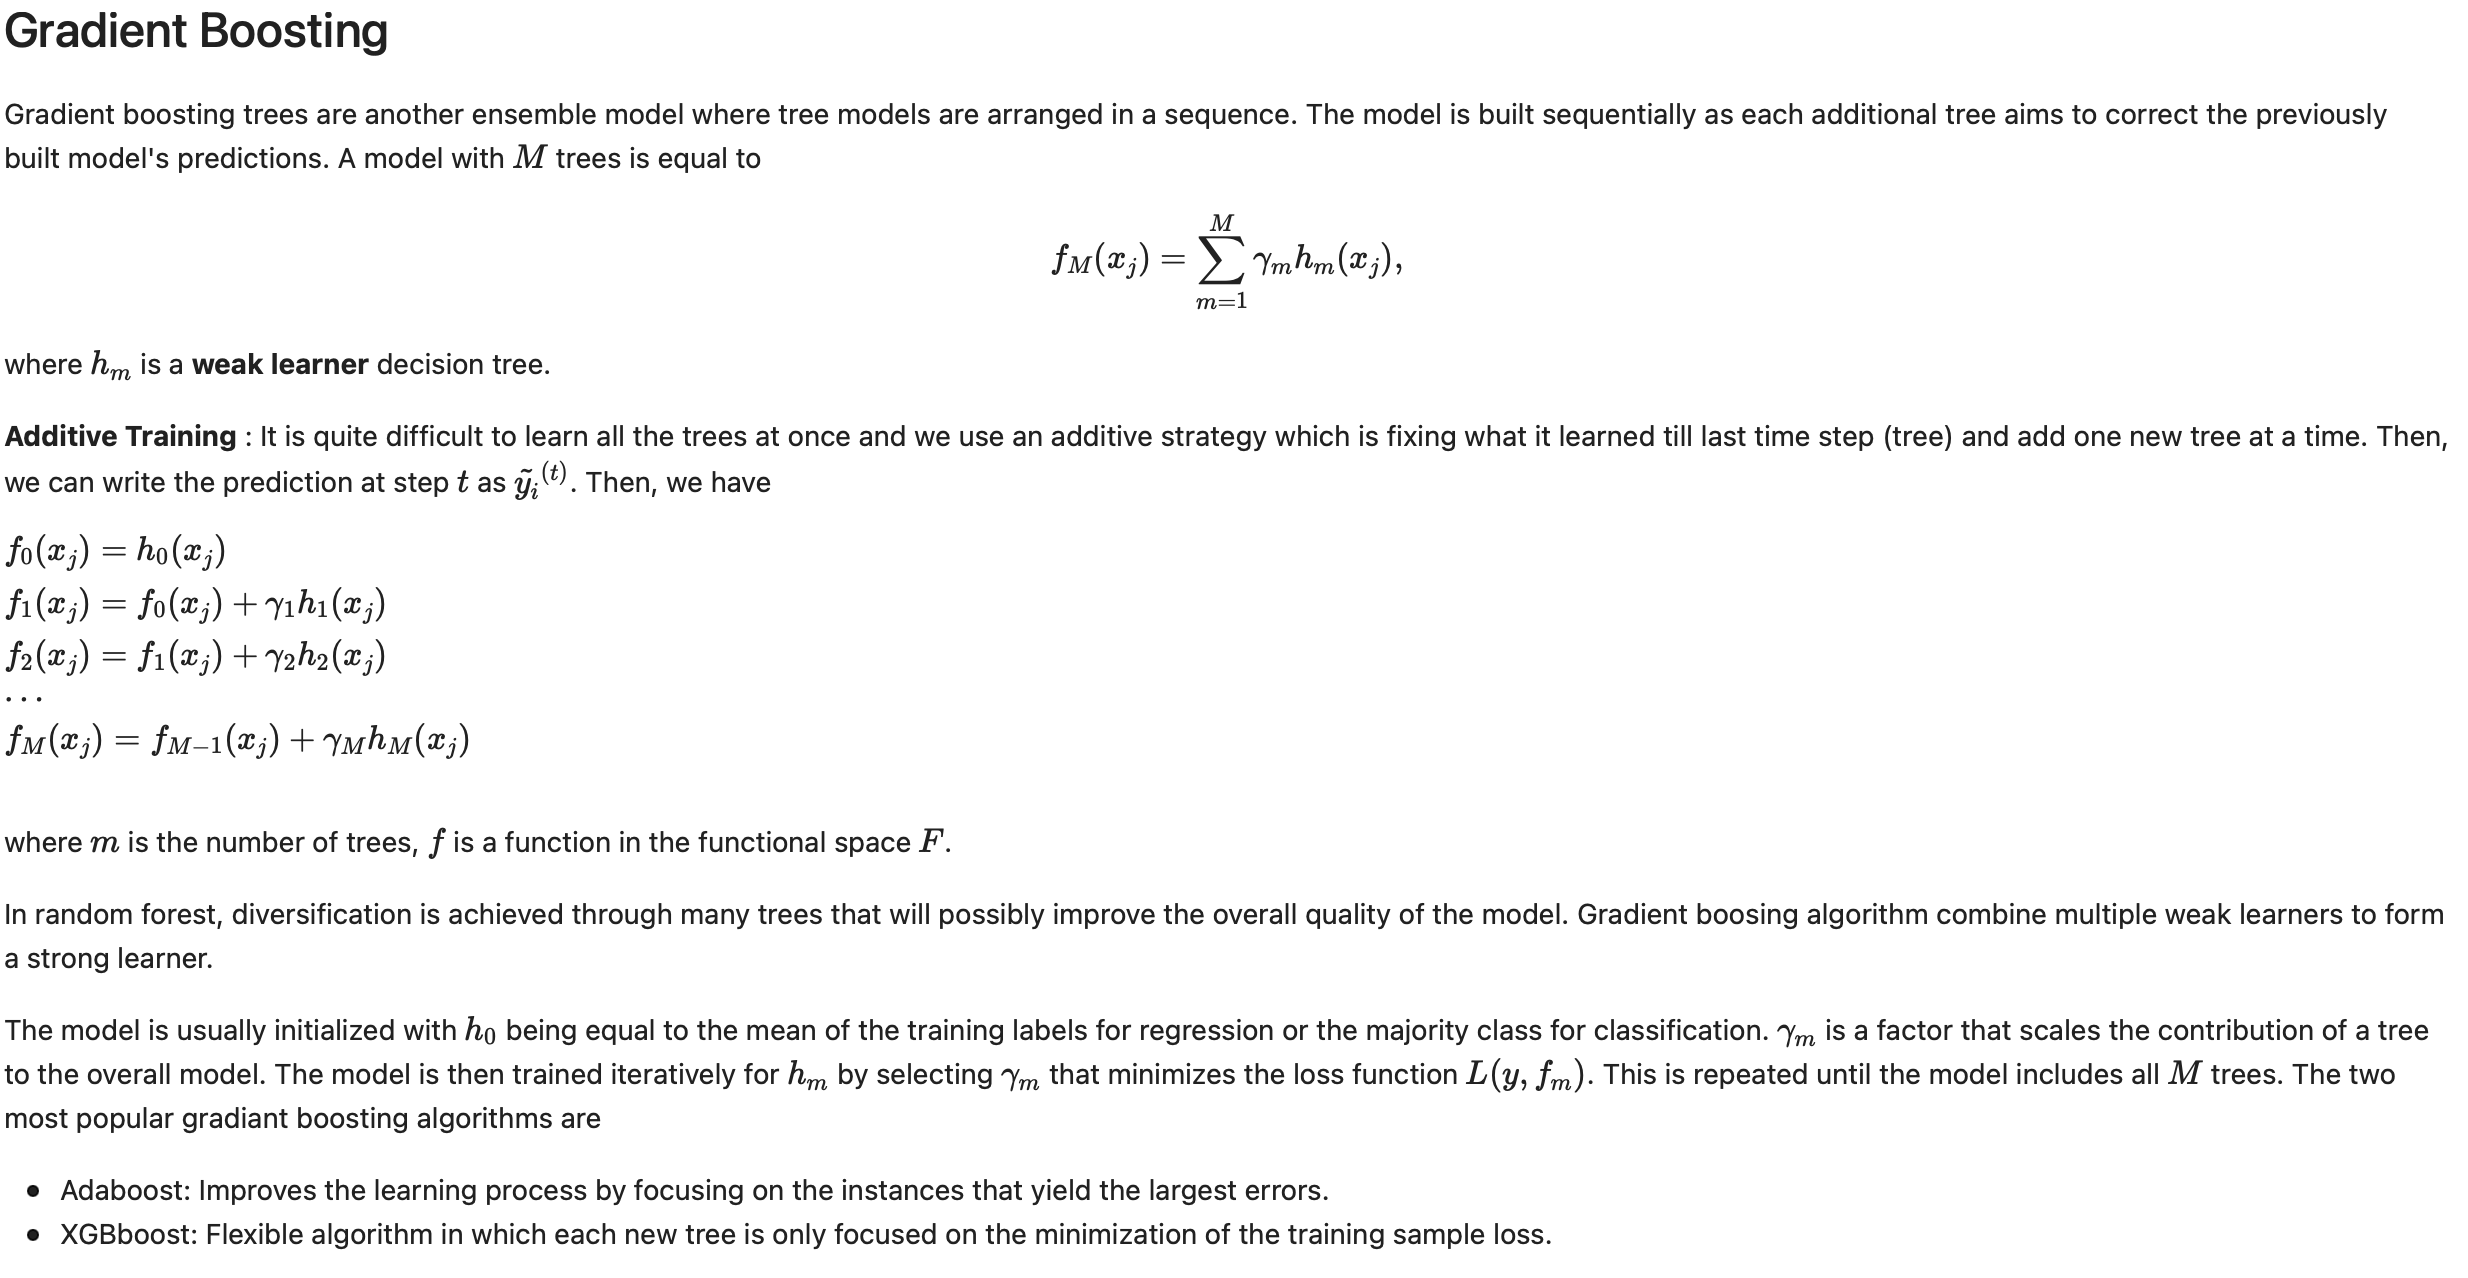

## XGBoost

https://xgboost.readthedocs.io/en/latest/tutorials/model.html#the-structure-score

Tree boosting is highly effective and widely used machine learning method. XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.

XGBoost, which is used widely by data scientists to achieve state-of-the-art results on many machine learning challenges. XGBoost initially started as a research project by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC) group. Initially, it began as a terminal application which could be configured using a libsvm configuration file.

XGBoost was designed to be used with large, complicated datasets and is one of the most popular machine learning algorithm to deal with structured data. It is an advance version of gradient boosting method that is designed to focus on computational speed and model efficiency. XGBoost is preferred over other tree based model as it supports
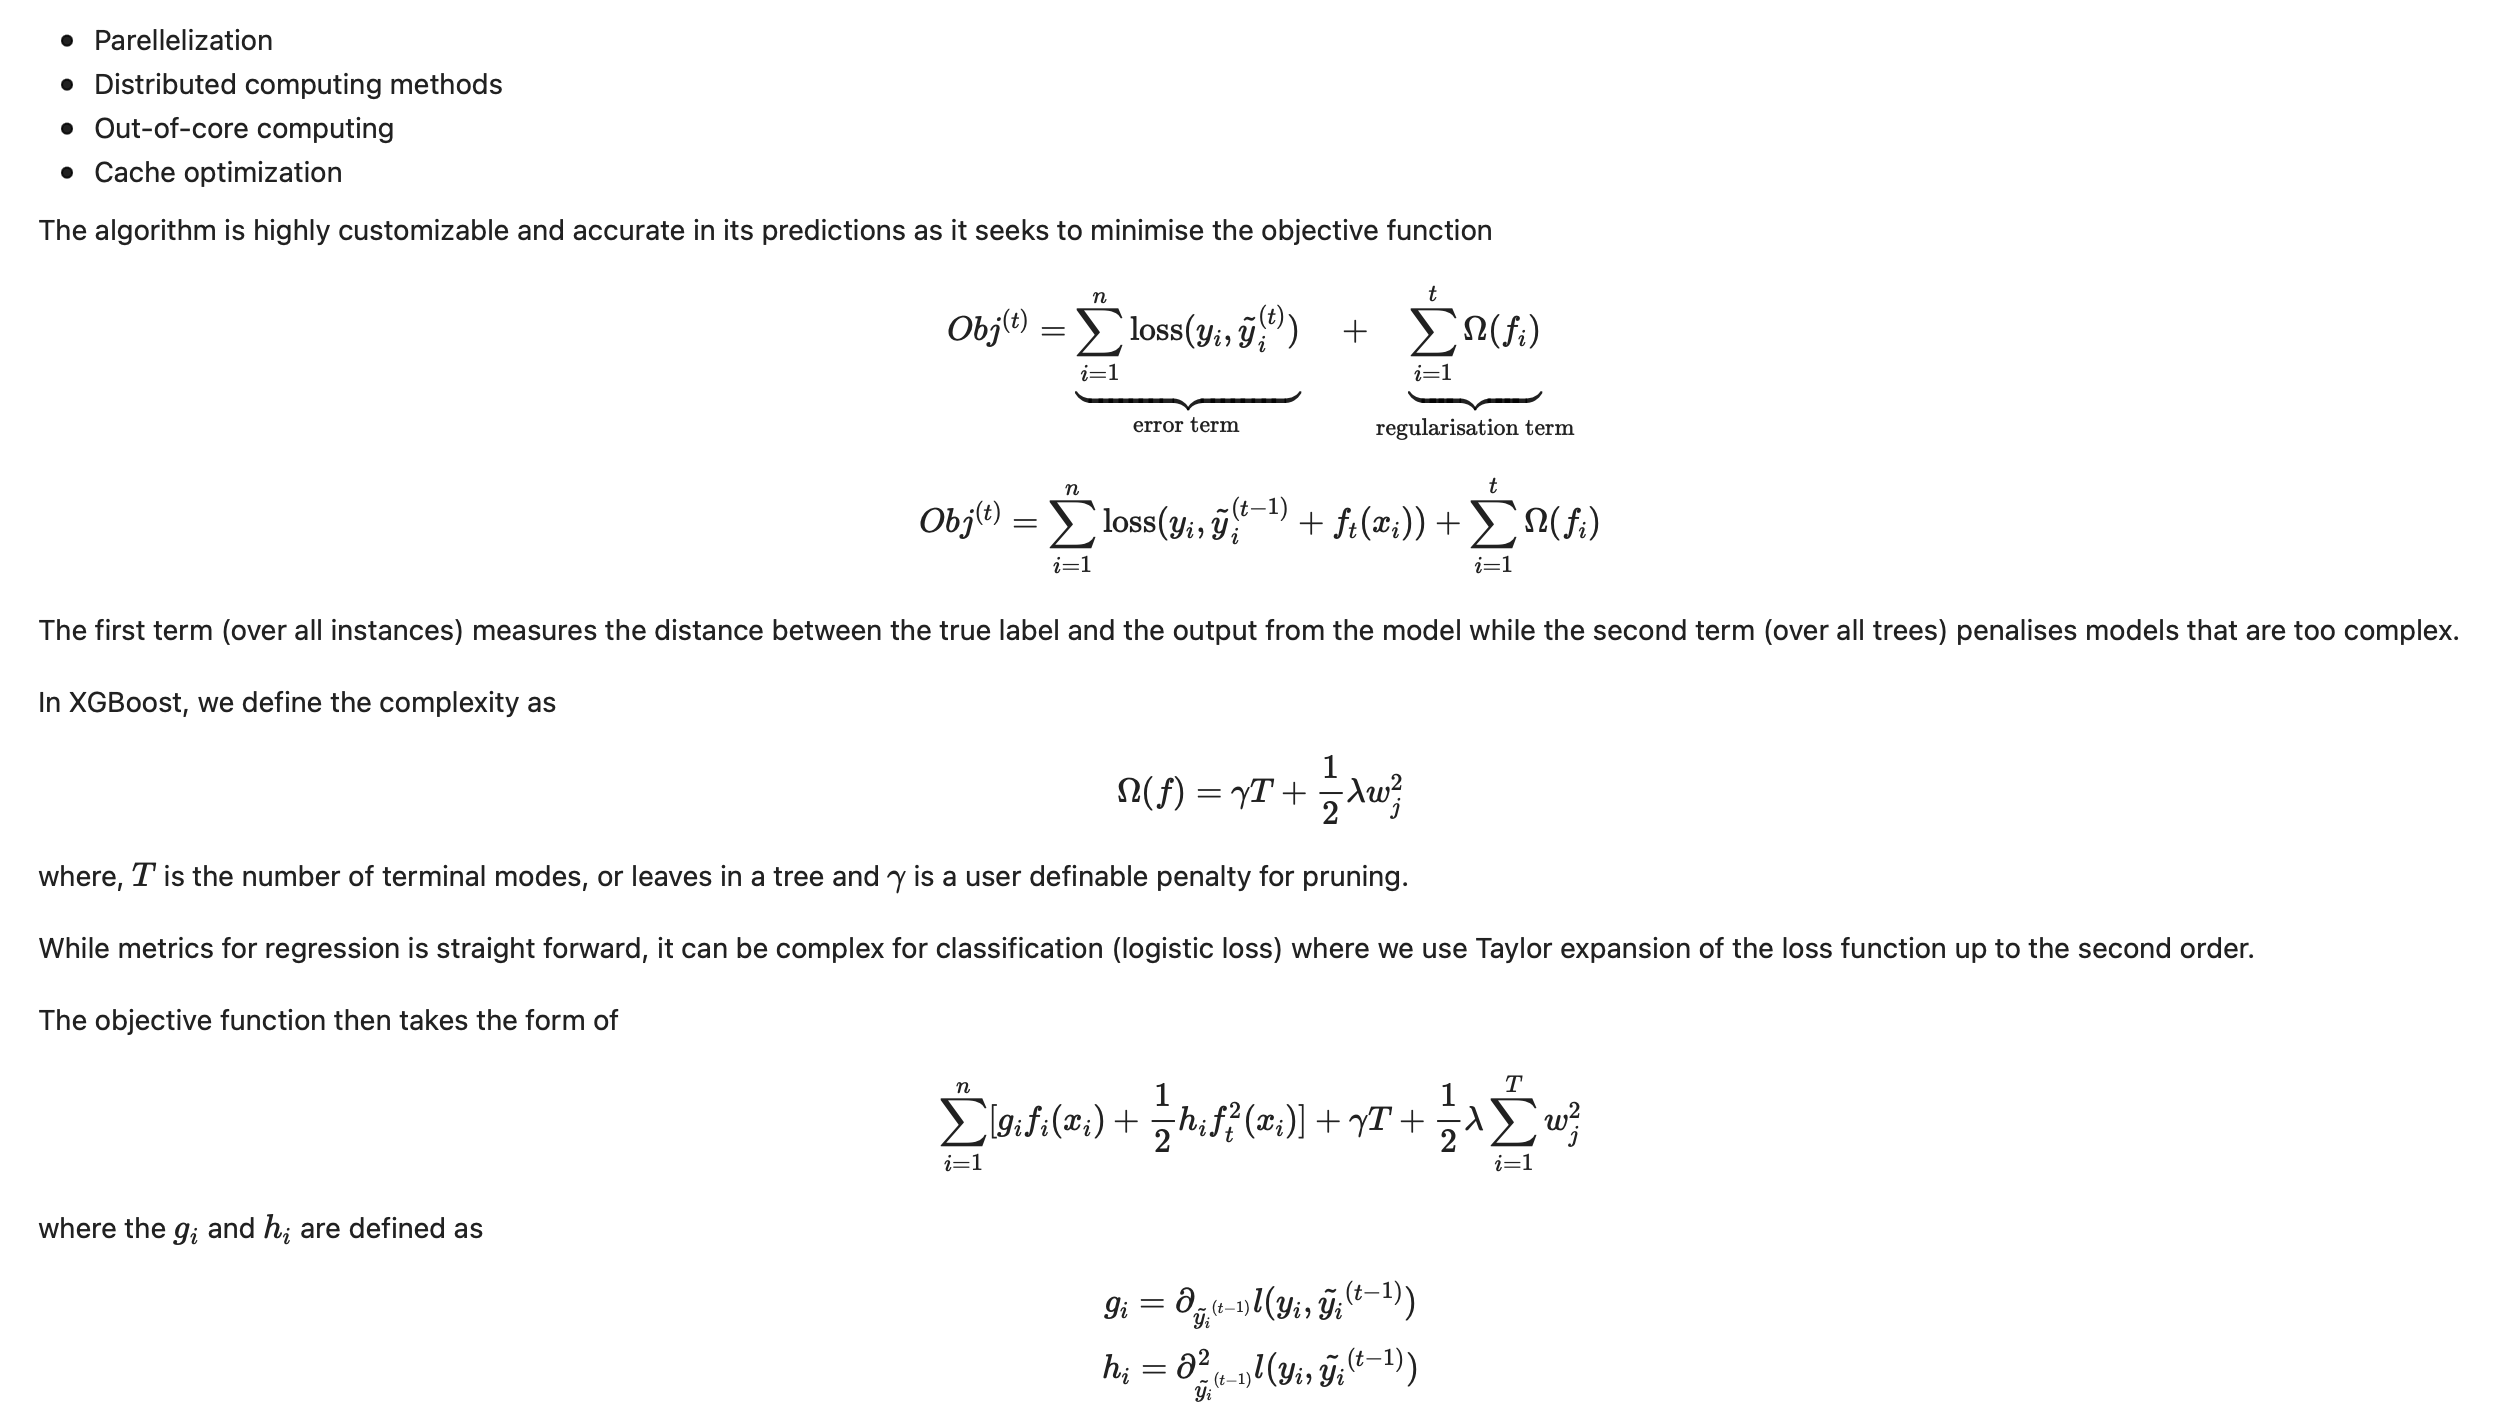
Parellelization
Distributed computing methods
Out-of-core computing
Cache optimization
The algorithm is highly customizable and accurate in its predictions as it seeks to minimise the objective function

## Implementation

We will use XGBClassifier from XGBoost library to predict future prices of the security by creating a custom list of features from the raw price series.

In [1]:
# Data manipulation 
import pandas as pd
import numpy as np

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# XGBoost Classifier
from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz

# Preprocessing & Cross validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load file
df = pd.read_csv('spy.csv', index_col=0, parse_dates=True)[['Adj Close']]

# Calculate returns
df['Returns'] = np.log(df).diff()

# Output first five values
df

,Adj Close,Returns
Date,,
2000-05-03,94.913345,NaN
2000-05-04,95.629852,0.007521
2000-05-05,96.788887,0.012047
2000-05-08,96.061813,-0.007540
2000-05-09,95.292702,-0.008039
...,...,...
2021-04-26,417.609985,0.002085
2021-04-27,417.519989,-0.000216
2021-04-28,417.399994,-0.000287


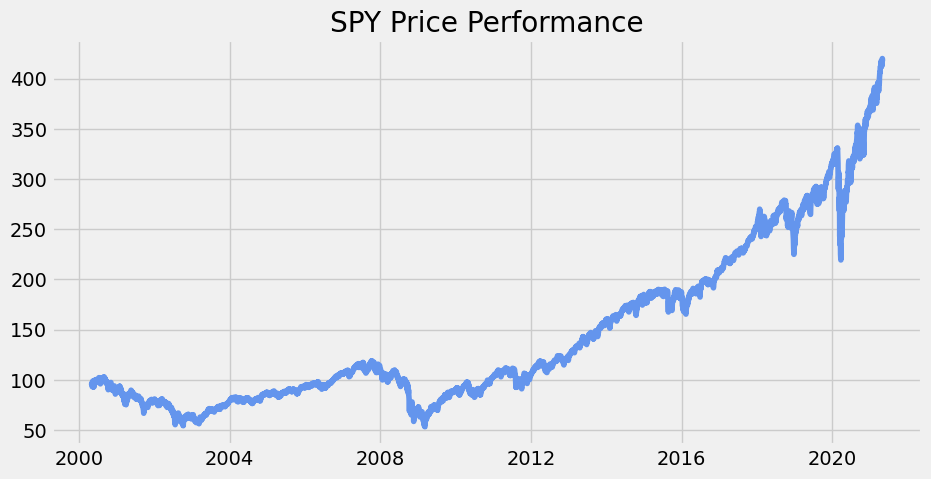

In [3]:
# Visualize raw price series
plt.figure(figsize=(10,5))
plt.title('SPY Price Performance')
plt.plot(df['Adj Close'], color='cornflowerblue');

## Feature Specification

Features or Predictors are also known as an independent variable which are used to determine the value of the target variable. We will use raw price to derive list of custom features.

In [4]:
# Create features (predictors) list
features_list = []
for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

# Drop NaN values
df.dropna(inplace=True)

In [5]:
features_list

['Ret_10',
 'Std_10',
 'Ret_15',
 'Std_15',
 'Ret_20',
 'Std_20',
 'Ret_25',
 'Std_25',
 'Ret_30',
 'Std_30',
 'Ret_35',
 'Std_35',
 'Ret_40',
 'Std_40',
 'Ret_45',
 'Std_45',
 'Ret_50',
 'Std_50',
 'Ret_55',
 'Std_55',
 'Ret_60',
 'Std_60']

## Define Label

Label or the target variable is also known as the dependent variable. Here, the target variable is whether SPY price will close up or down on the next trading day. If the tomorrow’s closing price is greater than 99.50% of today’s closing price with sharpe filter, then we will buy the SPY, else we will sell SPY.

We assign a value of +1 for the buy signal and -1 for the sell signal to the target variable. The target can be described as : 

In [14]:
df['Target'] = np.where(df['Adj Close'].shift(-1)>.995*df['Adj Close'],0,1) 

# Check output
df

,Adj Close,Returns,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,Std_25,...,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-07-28,96.045120,-0.022829,-0.062447,0.010516,-0.041358,0.010126,-0.014627,0.011306,-0.024547,0.010813,...,0.010377,0.015412,0.011521,-0.018972,0.011763,0.030680,0.012090,0.011854,0.012179,0
2000-07-31,96.657654,0.006357,-0.054435,0.011188,-0.033311,0.010396,-0.015827,0.011263,-0.009570,0.010787,...,0.010036,0.039075,0.011234,-0.000267,0.011672,0.014444,0.011735,0.010690,0.012169,0
2000-08-01,97.249107,0.006100,-0.040127,0.011699,-0.029322,0.010565,-0.023399,0.010871,-0.016266,0.010526,...,0.010071,0.044043,0.011261,0.021650,0.011476,0.009764,0.011675,0.004744,0.012094,0
2000-08-02,97.734917,0.004983,-0.027078,0.011922,-0.030857,0.010484,-0.000216,0.010174,-0.003883,0.010486,...,0.010086,0.016938,0.010238,0.034191,0.011435,-0.002392,0.011461,0.017267,0.012069,0
2000-08-03,98.410835,0.006892,-0.033973,0.011028,-0.028356,0.010613,-0.001073,0.010141,0.000215,0.010566,...,0.010086,0.021639,0.010280,0.055918,0.011244,-0.005133,0.011424,0.032198,0.012048,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.609985,0.002085,0.014399,0.007430,0.027309,0.006237,0.053184,0.006468,0.069735,0.007014,...,0.008881,0.071594,0.009533,0.069852,0.009104,0.081488,0.008723,0.103903,0.009258,0
2021-04-27,417.519989,-0.000216,0.011224,0.007425,0.027684,0.006227,0.053474,0.006461,0.061567,0.006953,...,0.008173,0.079100,0.009432,0.064709,0.009093,0.077345,0.008719,0.123910,0.008803,0
2021-04-28,417.399994,-0.000287,0.014357,0.007277,0.026240,0.006250,0.055843,0.006380,0.069181,0.006640,...,0.008030,0.077599,0.009436,0.065288,0.009090,0.069861,0.008686,0.107114,0.008600,0


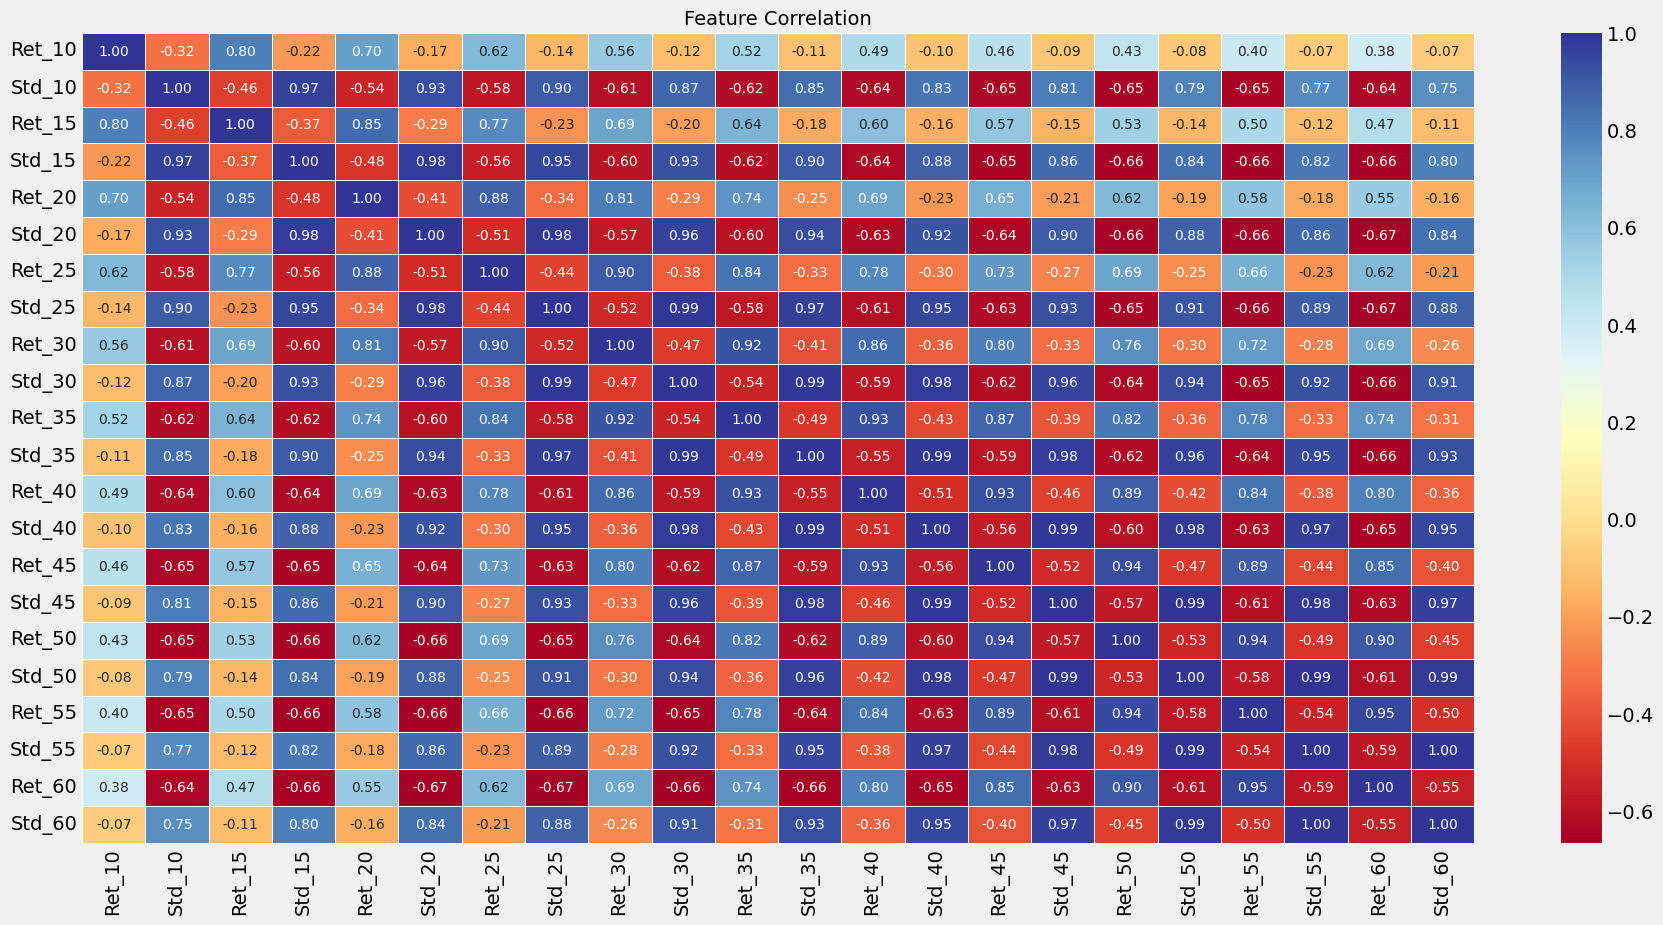

In [15]:
# Derive features correlation
import seaborn as sns
corrmat = df.drop(['Adj Close', 'Returns', 'Target'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, cmap='RdYlBu')
ax.set_title('Feature Correlation', fontsize=14, color='black');

In [16]:
# Convert to NumPy
X = df.drop(['Adj Close', 'Returns', 'Target'],axis=1)

X

,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,Std_25,Ret_30,Std_30,...,Ret_40,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60
Date,,,,,,,,,,,,,,,,,,,,,
2000-07-28,-0.062447,0.010516,-0.041358,0.010126,-0.014627,0.011306,-0.024547,0.010813,-0.039429,0.010596,...,-0.020047,0.010377,0.015412,0.011521,-0.018972,0.011763,0.030680,0.012090,0.011854,0.012179
2000-07-31,-0.054435,0.011188,-0.033311,0.010396,-0.015827,0.011263,-0.009570,0.010787,-0.024820,0.010602,...,-0.030960,0.010036,0.039075,0.011234,-0.000267,0.011672,0.014444,0.011735,0.010690,0.012169
2000-08-01,-0.040127,0.011699,-0.029322,0.010565,-0.023399,0.010871,-0.016266,0.010526,-0.031429,0.010377,...,-0.019986,0.010071,0.044043,0.011261,0.021650,0.011476,0.009764,0.011675,0.004744,0.012094
2000-08-02,-0.027078,0.011922,-0.030857,0.010484,-0.000216,0.010174,-0.003883,0.010486,-0.022862,0.010423,...,-0.010532,0.010086,0.016938,0.010238,0.034191,0.011435,-0.002392,0.011461,0.017267,0.012069
2000-08-03,-0.033973,0.011028,-0.028356,0.010613,-0.001073,0.010141,0.000215,0.010566,-0.015547,0.010516,...,-0.010551,0.010086,0.021639,0.010280,0.055918,0.011244,-0.005133,0.011424,0.032198,0.012048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,0.014399,0.007430,0.027309,0.006237,0.053184,0.006468,0.069735,0.007014,0.061315,0.007232,...,0.096700,0.008881,0.071594,0.009533,0.069852,0.009104,0.081488,0.008723,0.103903,0.009258
2021-04-27,0.011224,0.007425,0.027684,0.006227,0.053474,0.006461,0.061567,0.006953,0.055153,0.007204,...,0.072533,0.008173,0.079100,0.009432,0.064709,0.009093,0.077345,0.008719,0.123910,0.008803
2021-04-28,0.014357,0.007277,0.026240,0.006250,0.055843,0.006380,0.069181,0.006640,0.056128,0.007192,...,0.080079,0.008030,0.077599,0.009436,0.065288,0.009090,0.069861,0.008686,0.107114,0.008600


In [17]:
X.shape

(5222, 22)

In [18]:
# Define label or target 
y = df['Target']
y

Date
2000-07-28    0
2000-07-31    0
2000-08-01    0
2000-08-02    0
2000-08-03    0
             ..
2021-04-26    0
2021-04-27    0
2021-04-28    0
2021-04-29    1
2021-04-30    1
Name: Target, Length: 5222, dtype: int64

In [19]:
y.shape

(5222,)

## Split Data

In [20]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4177, 1045


## Fit Model
We will now create and train the XGBoost (Regessor). All the feature and label should have a similar scale and the scaling can be accomplished by using the StandardScaler transformer.

In [21]:
# Scale and fit the classifier model
xgb =  XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Predict Model

In [22]:
# Predicting the test dataset
y_pred = xgb.predict(X_test)

In [23]:
# Output prediction scoare
print(f'Train Accuracy: {xgb.score(X_train,y_train):0.4}')
print(f'Test Accuracy: {xgb.score(X_test,y_test):0.4}')

Train Accuracy: 0.9916
Test Accuracy: 0.7589


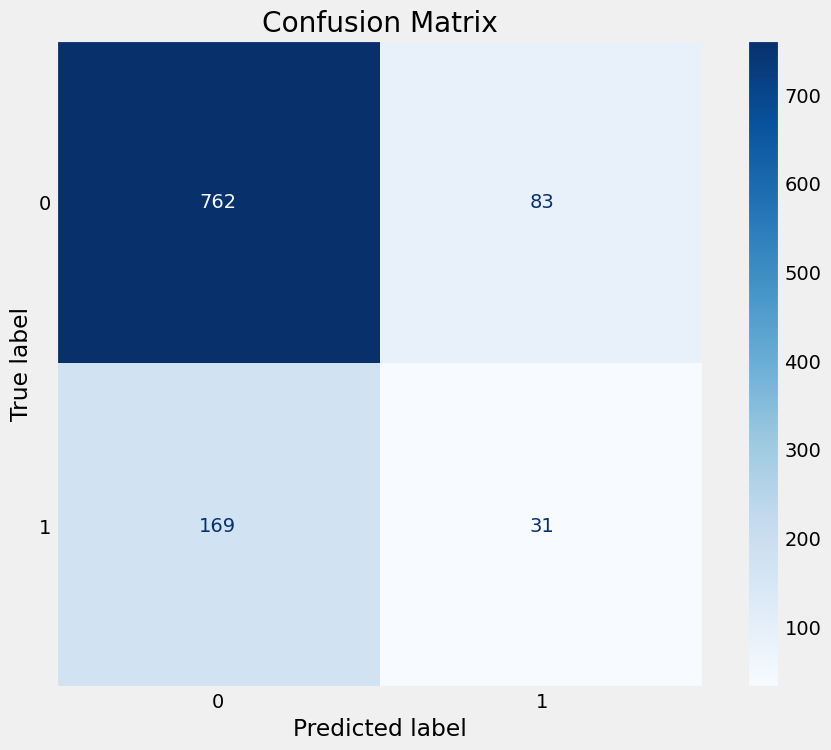

In [24]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(xgb, X_test, y_test, ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)

In [25]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       845
           1       0.27      0.15      0.20       200

    accuracy                           0.76      1045
   macro avg       0.55      0.53      0.53      1045
weighted avg       0.71      0.76      0.73      1045



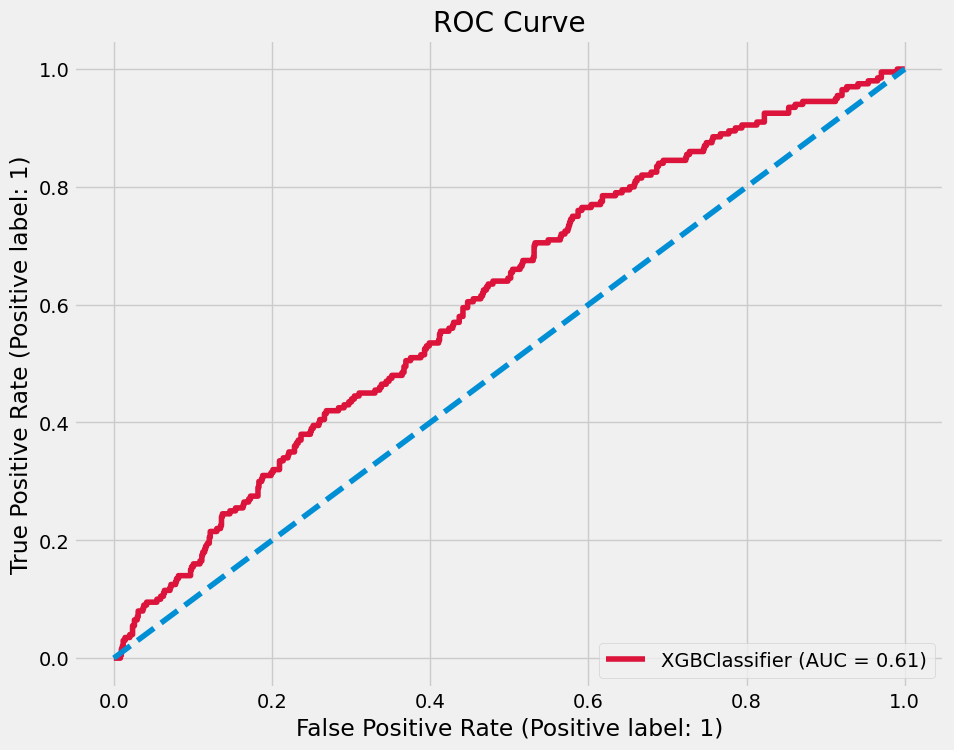

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc_curve(xgb, X_test, y_test, ax=ax, color='crimson')
ax.plot([0,1], [0,1], linestyle='--')
ax.set_title('ROC Curve');

## Hyper-parameter Tuning
Hyper-parameters are parameters that are not directly learnt within estimators. They are passed as arguments to the constructor of the estimator classes (Classifier in this case). It is possible and recommended to search the hyper-parameter space for the best cross validation score. Any parameter provided when constructing an estimator may be optimized in this manner.

We will tune the hyperparameters to select the best score by TimeSeriesSplit cross-validation. This is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set. Unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

## XGBoost's hyper-parameter

XGBoost has plethora of tuning parameters includeing the regulatization parameters and some of the most common hyperparameters are:

* learning rate: step size shrinkage used in update to prevents overfitting. Range is [0,1].
* max_depth: maximum depth of a tree.
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
* min_child_weight: minimum sum of instance weight needed in a child.
* gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. Large gamma will lead to more conservative algorithm.
Refer here for complete list of tuning parameters. 
https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

## RandomizedSearch

The RandomizedSearchCV implements a “fit” and a “score” method and perform randomized search on hyper parameters. The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.

In [27]:
# Timeseries CV 3-split
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X):
    print(train, test)

[   0    1    2 ... 1304 1305 1306] [1307 1308 1309 ... 2609 2610 2611]
[   0    1    2 ... 2609 2610 2611] [2612 2613 2614 ... 3914 3915 3916]
[   0    1    2 ... 3914 3915 3916] [3917 3918 3919 ... 5219 5220 5221]


In [28]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [29]:
# Get params list
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [30]:
# Hyper parameter optimization
param_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
              'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]}

In [31]:
random_search = RandomizedSearchCV(xgb, param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=tscv, random_state=42, verbose=1)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',...
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=0,
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=0, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=42, scoring='f1', verbose=1)

In [32]:
random_search.best_params_

{'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [33]:
random_search.best_score_

0.22665779422856297

## Verify Model

In [34]:
# Instantiate XGB model with param
cls = XGBClassifier(**random_search.best_params_) 
cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=15, max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

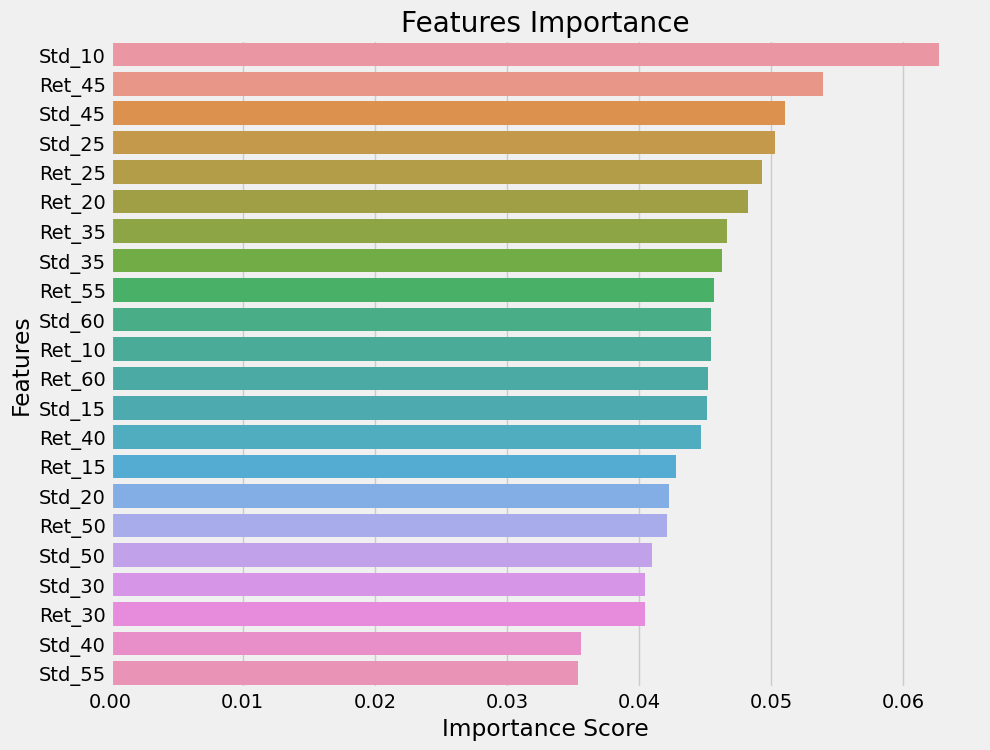

In [35]:
# Plot feature importance
# feature importance_type = 'gain'

fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': cls.feature_importances_,'Features': X.columns}).sort_values(by='Importance Score', ascending=False)

sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');

Importance type can be either of the following:

weight: the number of times a feature is used to split the data across all trees.
gain: the average gain across all splits the feature is used in.
cover: the average coverage across all splits the feature is used in.
total_gain: the total gain across all splits the feature is used in.
total_cover: the total coverage across all splits the feature is used in.
By default, feature_importances_ rank features based on the average gain across all splits. This can be changed using the plot_importance method.

## Tree Visualization

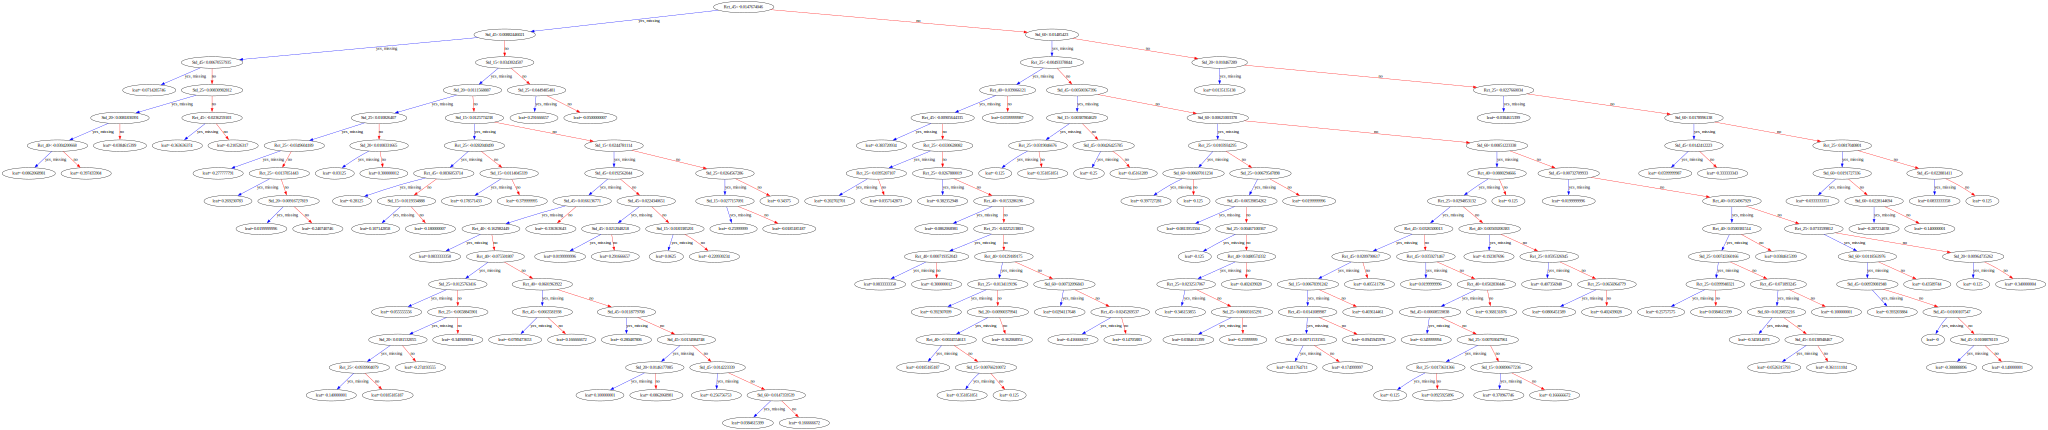

In [36]:
# change tree number to see the corresponding plot
to_graphviz(cls, num_trees=0, rankdir='UT') 

## Predict Refitted Model

In [37]:
# Predicting the test dataset
y_pred = cls.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
# Measure Accuracy
acc_train = accuracy_score(y_train, cls.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
acc_train, acc_test

(0.999281781182667, 0.7779904306220096)

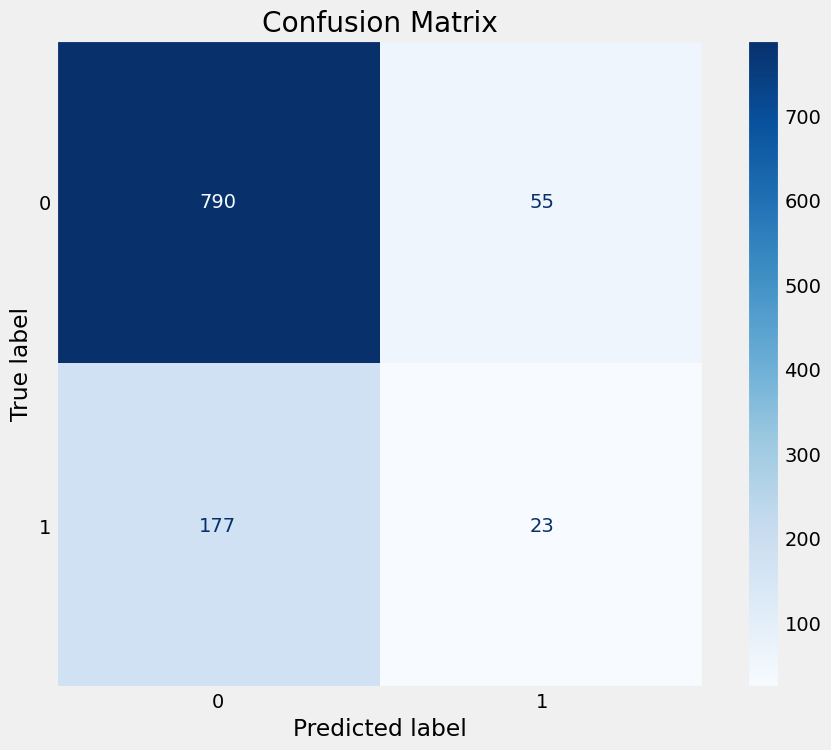

In [39]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)

In [40]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       845
           1       0.29      0.12      0.17       200

    accuracy                           0.78      1045
   macro avg       0.56      0.52      0.52      1045
weighted avg       0.72      0.78      0.74      1045



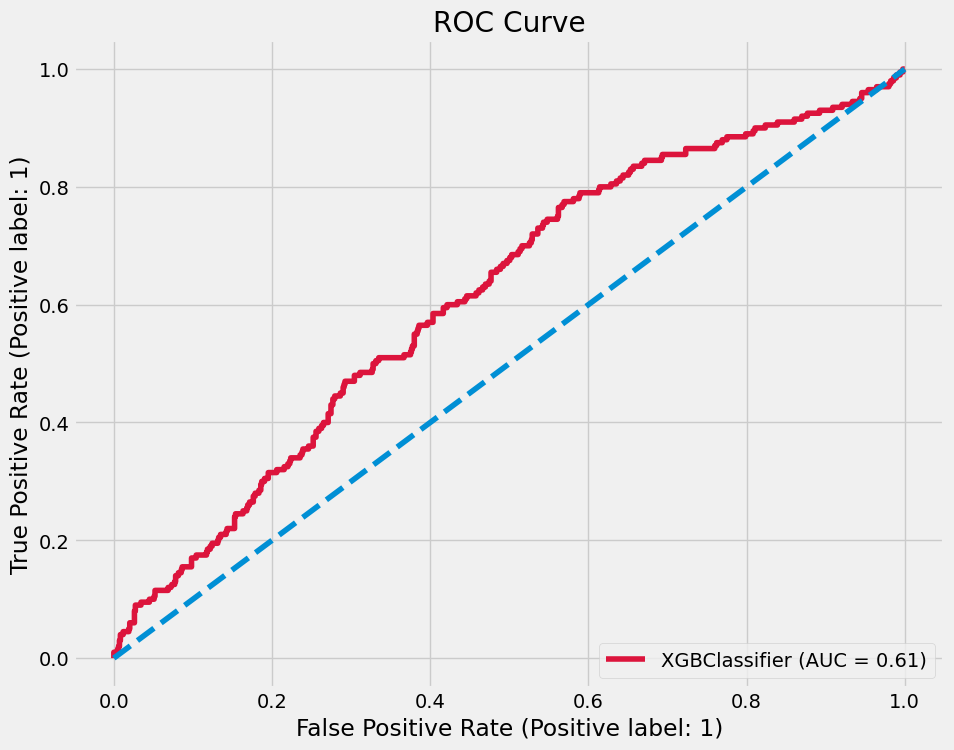

In [41]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc_curve(cls, X_test, y_test, ax=ax, color='crimson')
ax.plot([0,1], [0,1], linestyle='--')
ax.set_title('ROC Curve');

In [42]:
# Cross validation score
score=cross_val_score(cls,X_train,y_train,cv=tscv)
score

array([0.51005747, 0.66954023, 0.67097701, 0.76436782, 0.75431034])

In [43]:
print(f'Mean CV Score : {score.mean():0.4}')

Mean CV Score : 0.6739


## Trading Strategy

Let's now define a trading strategy. We assign a value of +1 for the buy signal and -1 otherwise from the predicted price y_pred for the outsample horizon. We then compare the result of this strategy with the buy and hold and visualize the performance of the Tree Algorithm.

In [44]:
# Create a new dataframe to subsume outsample data
df1 = df[-len(y_test):]

# Predict the signal and store in predicted signal column
df1['Signal'] = y_pred
    
# Calculate the strategy returns
df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(-1).fillna(0)

# Check the output
df1[['Adj Close', 'Returns', 'Signal', 'Strategy']]

,Adj Close,Returns,Signal,Strategy
Date,,,,
2017-03-08,218.677780,-0.001858,0,-0.0
2017-03-09,218.955078,0.001267,0,0.0
2017-03-10,219.722366,0.003498,0,0.0
2017-03-13,219.833298,0.000505,0,0.0
2017-03-14,218.992081,-0.003834,0,-0.0
...,...,...,...,...
2021-04-26,417.609985,0.002085,0,0.0
2021-04-27,417.519989,-0.000216,0,-0.0
2021-04-28,417.399994,-0.000287,0,-0.0


We'll now apply exponential function to arrive at the performance of the strategy and compare it with the simple Buy and Hold.

In [45]:
# Buy & Hold
cumret = df1['Returns'].cumsum().apply(np.exp)

# Tree Algorithm
cumstg = df1['Strategy'].cumsum().apply(np.exp)

print(f'Buy & Hold Returns \t {cumret[-1]:0.4}')
print(f'Strategy Returns \t {cumstg[-1]:0.4}')

Buy & Hold Returns 	 1.905
Strategy Returns 	 1.141


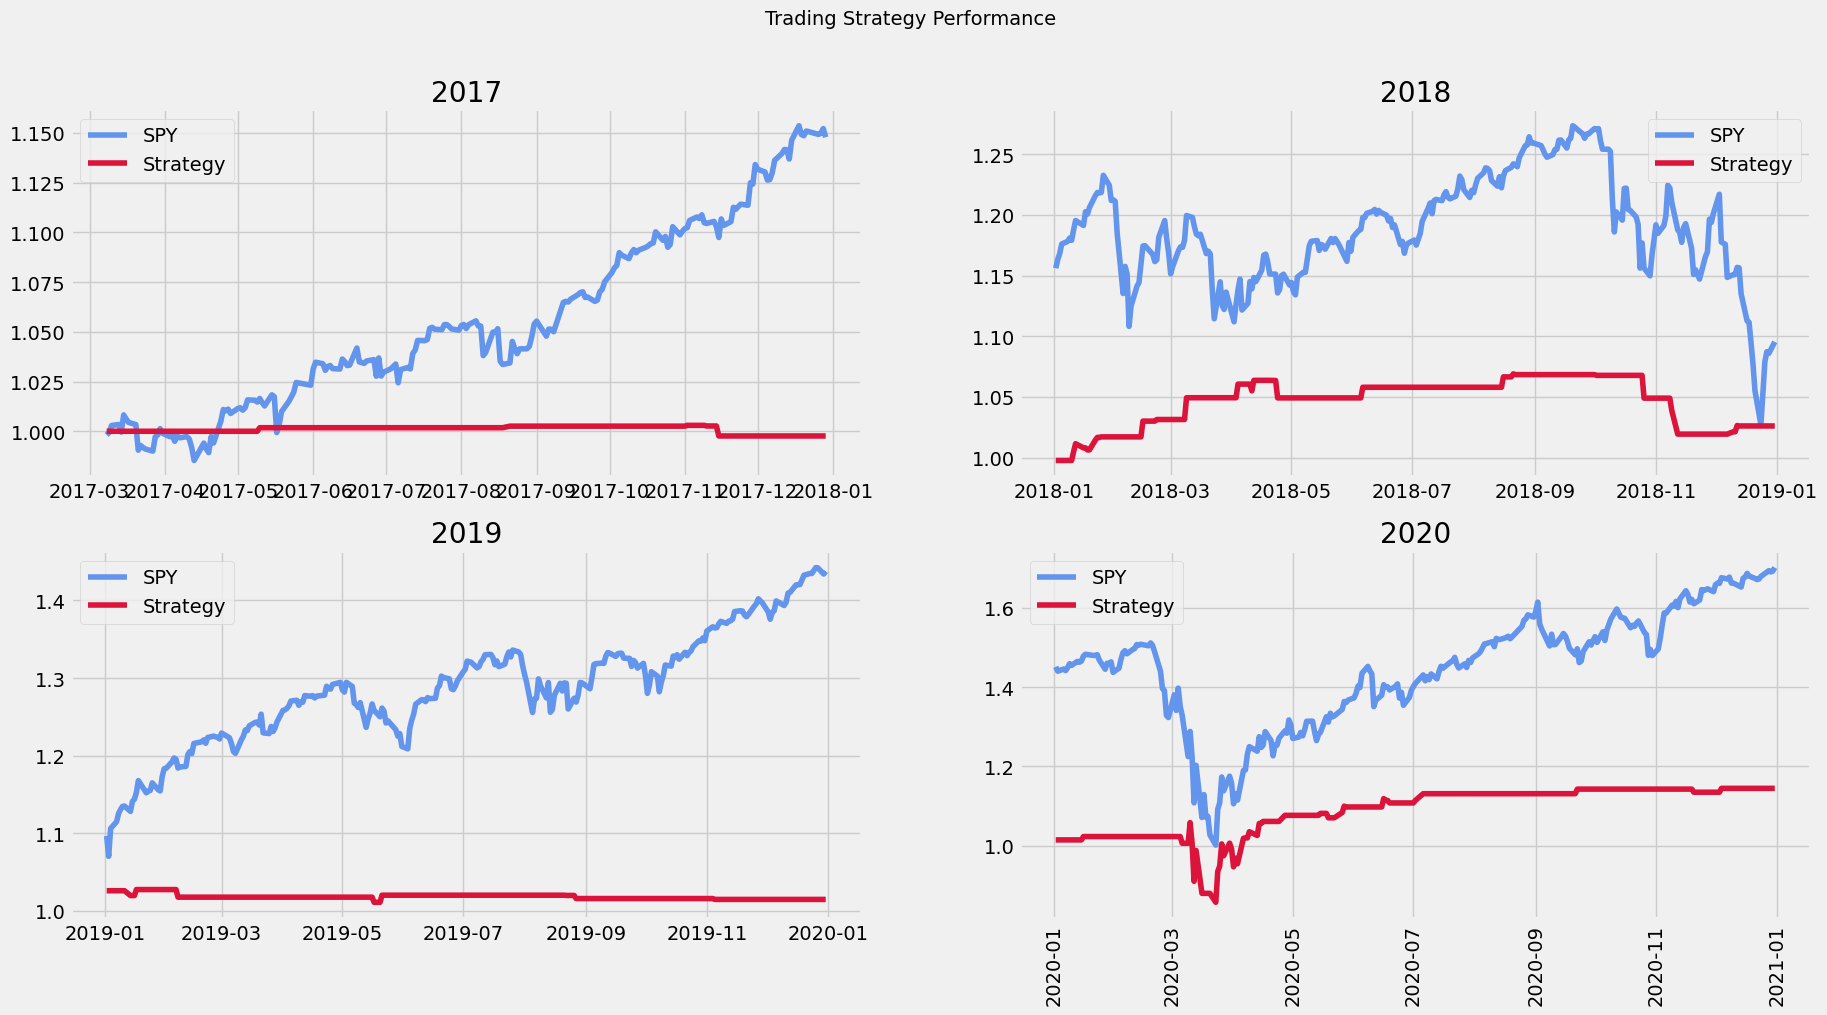

In [46]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))

# 2017
ax[0,0].plot(cumret['2017'], label ='SPY', color ='cornflowerblue')
ax[0,0].plot(cumstg['2017'], label ='Strategy', color ='crimson')
# 2018
ax[0,1].plot(cumret['2018'], label ='SPY', color ='cornflowerblue')
ax[0,1].plot(cumstg['2018'], label ='Strategy', color ='crimson')
# 2019
ax[1,0].plot(cumret['2019'], label ='SPY', color ='cornflowerblue')
ax[1,0].plot(cumstg['2019'], label ='Strategy', color ='crimson')
# 2020
ax[1,1].plot(cumret['2020'], label ='SPY', color ='cornflowerblue')
ax[1,1].plot(cumstg['2020'], label ='Strategy', color ='crimson')
ax[1,1].tick_params(axis='x', rotation=90)

# Set axis title
ax[0,0].set_title('2017'), ax[0,1].set_title('2018'), ax[1,0].set_title('2019'), ax[1,1].set_title('2020')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

fig.suptitle('Trading Strategy Performance', fontsize=14);

## Strategy Performance

In [47]:
# Performance measures
import pyfolio as pf

Start date,2017-03-08
End date,2021-04-30
Total months,49
,Backtest
Annual return,2.5%
Cumulative returns,10.6%
Annual volatility,12.2%
Sharpe ratio,0.26
Calmar ratio,0.11
Stability,0.35
Max drawdown,-21.3%


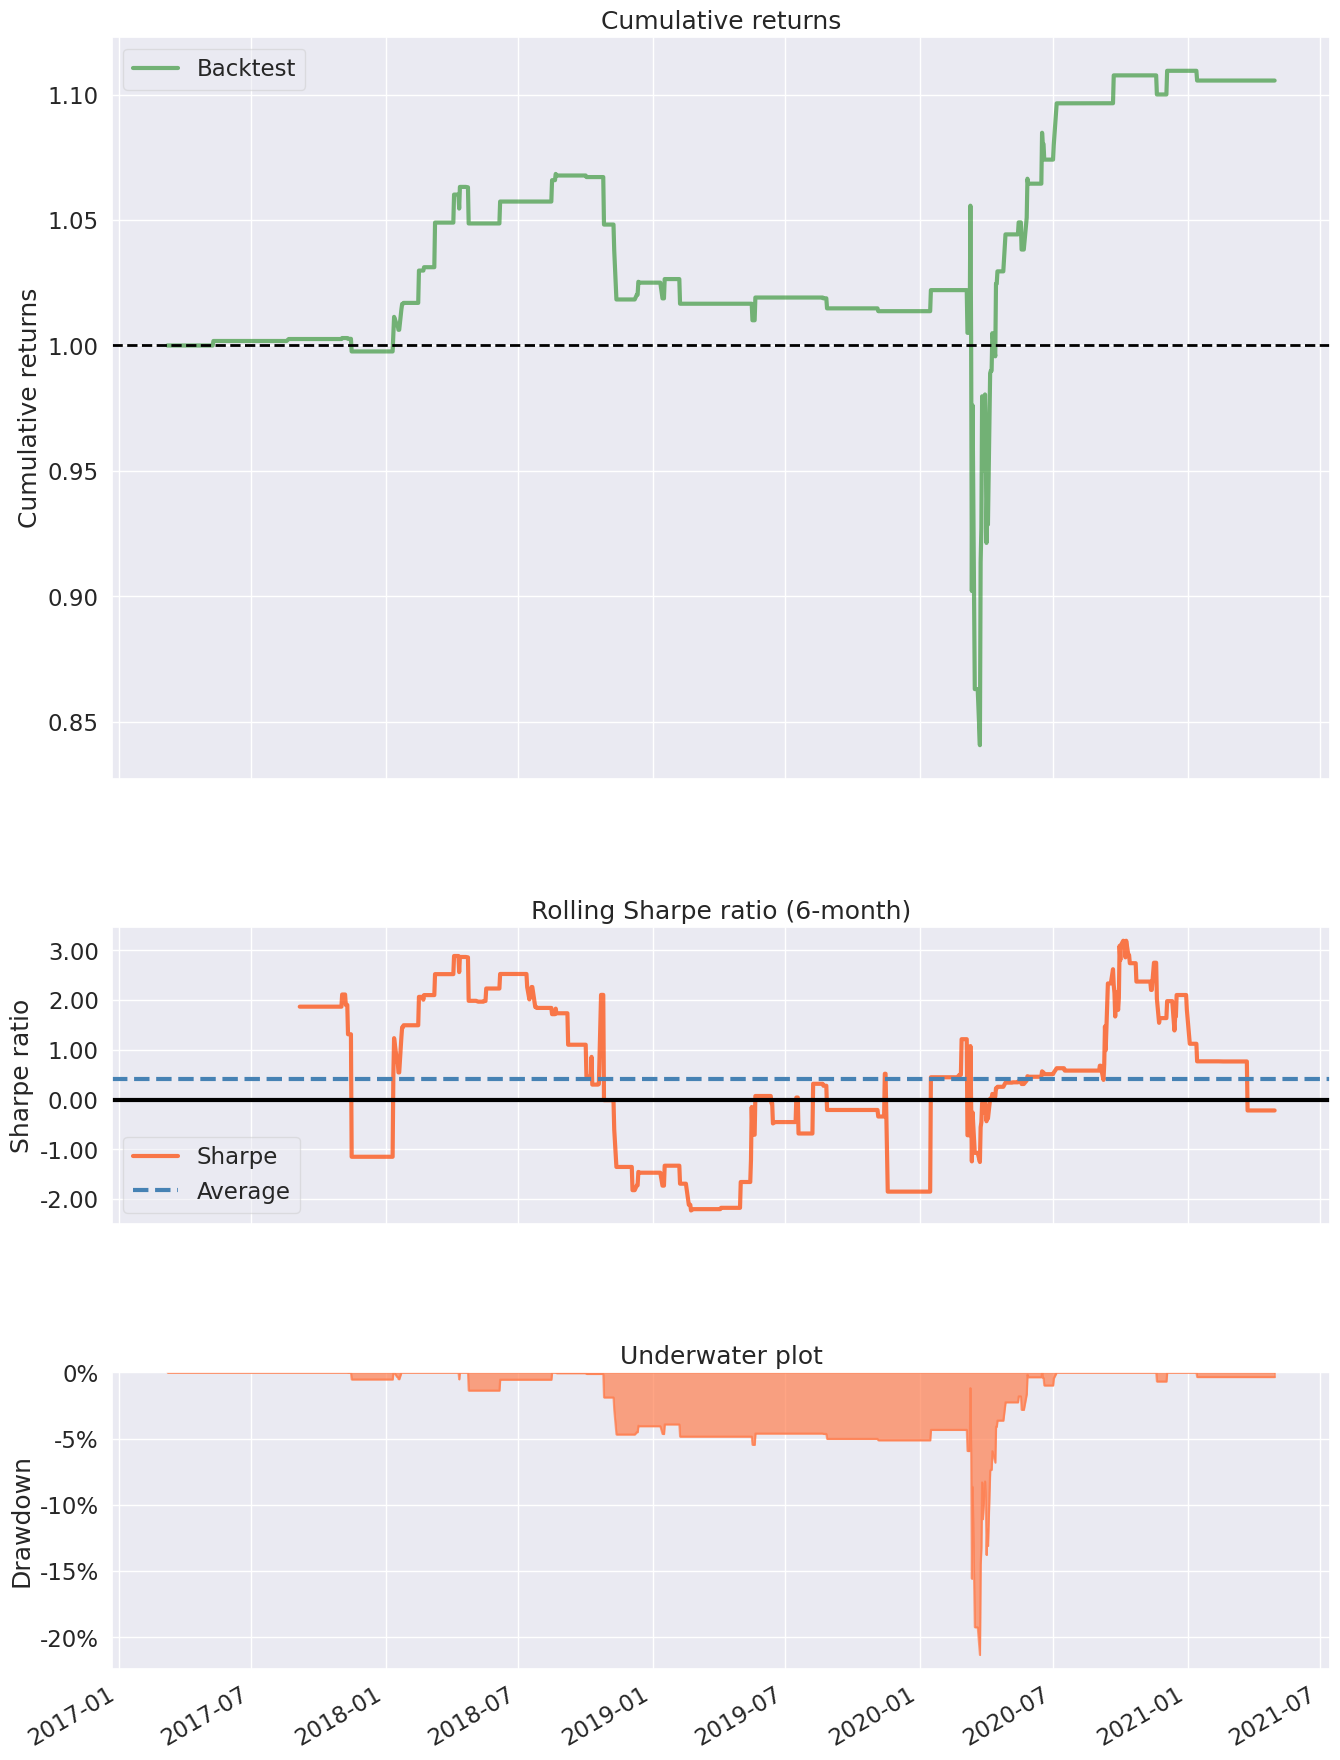

In [48]:
# Create tear sheet
pf.create_simple_tear_sheet(df1['Strategy'])

reference

https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f